# Reddit Comments Classification

In [1]:
'''We based our Reddit comments classifier of that made public by Davidson et al. Their
complete dataset can be found at https://github.com/t-davidson/hate-speech-and-offensive-language

@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, 
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
  }
'''

"We based our Reddit comments classifier of that made public by Davidson et al. Their\ncomplete dataset can be found at https://github.com/t-davidson/hate-speech-and-offensive-language\n\n@inproceedings{hateoffensive,\n  title = {Automated Hate Speech Detection and the Problem of Offensive Language},\n  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, \n  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},\n  series = {ICWSM '17},\n  year = {2017},\n  location = {Montreal, Canada},\n  pages = {512-515}\n  }\n"

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
RANDOM_SEED = 697

# Loading the Davidson et al. Dataset to Train the Classifier

<AxesSubplot:>

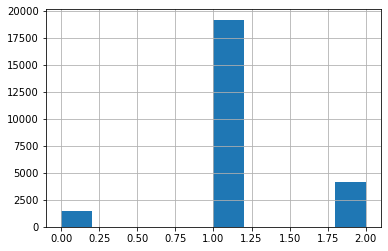

In [4]:
df = pd.read_csv("labeled_data.csv")
df['class'].hist()

In [5]:
tweets=df.tweet
len(tweets)

24783

# Feature generation for the Davidson et al. Twitter Dataset

# Part 1 - Preprocess, Tokenize and TF-IDF Vectorization

In [6]:
stopwords=nltk.corpus.stopwords.words("english")

'''These exclusions have been...excluded because they are irrelevent to Reddit'''
# other_exclusions = ["#ff", "ff", "rt"]
# stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was update here,
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    
    '''ORIGINAL CODE UPDATED: A bug in the original code was update here,
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip() was changed to
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()'''
    
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/cdallago/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


# Part 2 - POS Tagging

In [7]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
    
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

# Part 3 - Sentiment Analysis and Text & Readability Scores

In [8]:
#Finally we get sentiment analysis and other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet) #Sentiment analysis
    
    words = preprocess(tweet) #Get text only
    
    # Text and Readability feature scores 
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    '''The Twitter-specific features are preserved as they include urls and hashtags,
    however, retweets were excluded as they are irrelevent to Reddit posts'''
    twitter_objs = count_twitter_objs(tweet)
    # retweet = 0
    # if "rt" in words:
        # retweet = 1
        
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0]] # retweets excluded from the original features
    
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls"]

feats = get_feature_array(tweets)

In [9]:
#Now join them all up to create the final matrix
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(24783, 11550)

In [10]:
'''These feature names are unnecessary for running the model but allow us to better 
visualize the features.'''

# Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [11]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

'''ORIGINAL CODE UPDATED:
random_state=42 was changed to random_state=RANDOM_SEED, and
test_size=0.1 was changed to test_size=0.3'''

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.3)

In [12]:
'''The model uses a multi-class classifier with 5-fold cross-validation to predict the 
class labels.  It uses logistic regression with an L1 penalty to select the best features 
and reduce dimensionality, and L2 regularization to predict the class in the final model. 
Davidson et al. tested a variety of models including: logistic regression, naıve Bayes, 
decision trees, random forests, and linear SVMs, and found that logistic regression and 
linear SVMs performed similarly with the highest accuracy after using grid-search to 
iterate over the models and parameters. “A separate classifier is then trained for each 
class and the class label with the highest predicted probability across all classifiers is 
assigned to each tweet.”'''


'''ORIGINAL CODE UPDATED:
solver='liblinear', was added to the Logistic Regression parameters.'''

pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01, solver='liblinear'))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2', solver='liblinear'))])

param_grid = [{}] # Optionally add parameters here

'''ORIGINAL CODE UPDATED: 
shuffle=True, was added to the StratifiedKFold parameters,
random_state=42 was changed to random_state=RANDOM_SEED'''

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5,
                                              shuffle=True,
                                              random_state=RANDOM_SEED).split(X_train, y_train), 
                           verbose=2)

In [13]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   4.8s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.9s
[CV] END .................................................... total time=   4.5s
[CV] END .................................................... total time=   4.5s


In [14]:
y_preds = model.predict(X_test)

# Evaluating the Davidson et al. Results

In [15]:
report = classification_report( y_test, y_preds )

In [16]:
print(report)
# Davidson Twitter Dataset

              precision    recall  f1-score   support

           0       0.43      0.58      0.49       438
           1       0.97      0.91      0.94      5741
           2       0.83      0.95      0.89      1256

    accuracy                           0.90      7435
   macro avg       0.74      0.81      0.77      7435
weighted avg       0.91      0.90      0.90      7435



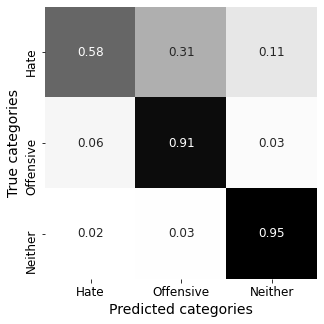

In [17]:
'''In their analysis, Davidson et al. write that, “far fewer tweets are classified as more 
offensive or hateful than their true category...suggesting that the model is biased towards 
classifying tweets as less hateful or offensive than the human coders.”
'''

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<AxesSubplot:>

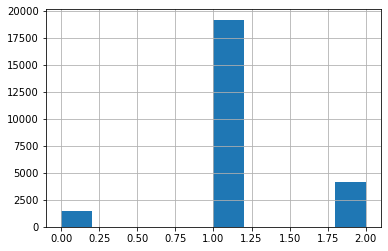

In [18]:
#True distribution
y.hist()

<AxesSubplot:>

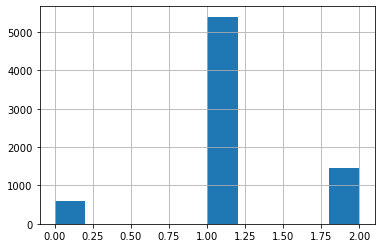

In [19]:
#Predicted distribution
pd.Series(y_preds).hist()

# Vectorize and transform the Reddit Comments Data to apply the classifier

In [20]:
comments_df = pd.read_csv('comments_df.csv')
comments = comments_df.body

In [21]:
'''This block of code takes a while to run, as it performs all three steps of feature
extraction.'''

# Using the same methods as above, we construct a tfidf matrix using the vectorizer 
# and get relevant scores.

vectorizer.fit_transform(tweets).toarray()
comments_tfidf = vectorizer.transform(comments).toarray()
comments_vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
comments_idf_vals = vectorizer.idf_
comments_idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

# Similarly we tokenize the comments to get the POS tags
comment_tags = []
for t in comments:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    comment_tags.append(tag_str)

# Then construct a POS TF matrix using the pos_vectorizer from above, resulting in 
# a vocab dictionary

pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
comments_pos = pos_vectorizer.transform(pd.Series(comment_tags)).toarray()
comments_pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

# Finally we get the sentiment and other features
comments_feats = get_feature_array(comments)

# Join them up as above, and check to make sure each row is of the same length as in the
# Davidson et al. dataset so that the model will run
comments_M = np.concatenate([comments_tfidf,comments_pos,comments_feats],axis=1)
comments_M.shape

(273461, 11550)

In [180]:
'''Again, this is unnecessary for running the model but allows us to better visualize the
features.'''

#Finally get a list of variable names
comments_variables = ['']*len(comments_vocab)
for k,v in comments_vocab.items():
    comments_variables[v] = k

comments_pos_variables = ['']*len(comments_pos_vocab)
for k,v in comments_pos_vocab.items():
    comments_pos_variables[v] = k

comments_feature_names = comments_variables+comments_pos_variables+other_features_names
# comments_feature_names

# Using the Model to Predict Reddit Labels

In [24]:
comment_labels = model.predict(comments_M)

In [178]:
# Add the labels back into the original comments dataset
comments_df['label'] = comment_labels

<AxesSubplot:>

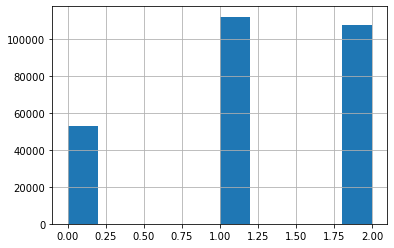

In [30]:
'''We see a somewhat similar distribution to the Davidson et al. results, in that the most 
comments classified as offensive and the least classified as hate, however our results 
contain far more comments classified as neither.
As mentioned by Davidson et al., the model appears to be biased towards classifying tweets 
as less hateful or offensive than a human coder would.
'''

# Distribution of Reddit dataset
comments_df['label'].hist()


Total comments cut:  64917
Hate comments cut:  13125
Offensive comments cut:  13289
Neither comments cut:  38503


<AxesSubplot:>

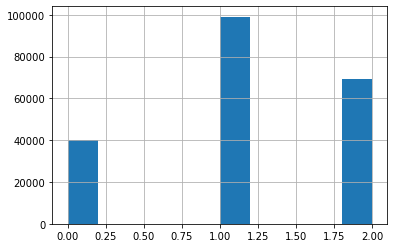

In [201]:
'''Dropping duplicates and comments with links or the phrase "I am a bot" shows that a
majority of those posts had been classified as neither. There also seem to be a number of
Swedish posts (<100) in the "neither" category, and I am working on a comprehensive way to
delete those.'''

cleaned_df = comments_df.copy()
cleaned_df.drop(cleaned_df[cleaned_df.body.str.contains('I am a bot') == True].index, inplace=True)
cleaned_df.drop(cleaned_df[cleaned_df.body.str.contains('http') == True].index, inplace=True)
cleaned_df = cleaned_df.drop_duplicates(subset=['body'])
print('Total comments cut: ',len(comments_df)-len(cleaned_df))
print('Hate comments cut: ',len(comments_df[comments_df.label == 0])-len(cleaned_df[cleaned_df.label == 0]))
print('Offensive comments cut: ',len(comments_df[comments_df.label == 1])-len(cleaned_df[cleaned_df.label == 1]))
print('Neither comments cut: ',len(comments_df[comments_df.label == 2])-len(cleaned_df[cleaned_df.label == 2]))
cleaned_df['label'].hist()


In [ ]:
'''Something to note going forward is that comments using the word "slut" overwhelmingly 
appear in the neither category, with many instances using the term in a way that could be 
considered either hateful or offensive. In total the word appears >50,000 times in this 
category, and while some instances may considered more benign (ie. "slut-shaming"), it may 
be of importance for further analysis.'''

In [177]:
'''Uncomment to create a CSV of the raw comments dataset with labels.'''
# comments_df.to_csv('comments_df_labeled.csv')

In [ ]:
'''Uncomment to create a CSV of the cleaned comments dataset with labels.'''
# cleaned_df.to_csv('comments_df_labeled_cleaned.csv')